# General Pipeline of a NN PyTorch Project

### Create Variables

Inputs

### Establish Networks (Funcs with variables)

Outputs

### Define Loss

Loss = Target - Outputs

### Calculate gradient to backpropagate Loss (Done by PyTorch)

gradient

### Update Weights with SGD or BGD

In [1]:
"""N, D = 3, 4

x = Variable(torch.randn(N, D).cuda(), requires_grad=True)
y = Variable(torch.randn(N, D).cuda(), requires_grad=True)
z = Variable(torch.randn(N, D).cuda(), requires_grad=True)

a = x * y
b = a + z
c = torch.sum(b)

c.backward()
print(x.grad.data)
print(y.grad.data)
print(z.grad.data)"""

'N, D = 3, 4\n\nx = Variable(torch.randn(N, D).cuda(), requires_grad=True)\ny = Variable(torch.randn(N, D).cuda(), requires_grad=True)\nz = Variable(torch.randn(N, D).cuda(), requires_grad=True)\n\na = x * y\nb = a + z\nc = torch.sum(b)\n\nc.backward()\nprint(x.grad.data)\nprint(y.grad.data)\nprint(z.grad.data)'

    1. Understand data with EDA (torch.utils.data.Datatset)

    2. Implement model correctly (torch.nn)

    3. Design Task specific Loss function (torch.nn), optimizer (torch.optim)

    4. Training

    4. Evaluation

### For monitoring progress

Tensorboardx

lear.ai


### Error Analysis and visualization

Plot intermediate feature maps

What if our network is not performing well for certain classes (Class imbalance problem)

Solution: Give larger weights to class that perform poorly

# Implementation of a simple Neural Network in Pytorch without using torch.autograd

In [2]:
import torch
import numpy as np
import torch.nn as nn

import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score

from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
class MNISTDataset(Dataset):

    def __init__(self, data, transform=None):
        """
        data should be a X,y tuple matrix
        """
        self.X, self.y = data
        self.X = torch.tensor(self.X, dtype=torch.float)

        # Normalize data
        mean = self.X.mean(0)
        std = self.X.std(0)
        std[std == 0] = 1.
        self.X -= mean
        self.X /= std

        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        """
        Returns one data sample (X[index,:]) and its label (y[index])
        """
        return self.X[index, :], self.y[index]

## Neural Network hyperparameters

In [4]:
batch_size = 100
random_seed= 42
test_split = .1
validation_split = .2
shuffle_dataset = True

## Loading our dataset

In [5]:
# download training data from sklearn.datasets
mnist_data = MNISTDataset(load_digits(return_X_y=True))

## Creating splits for train, validation, and test

In [6]:
dataset_size = len(mnist_data)
indices = list(range(dataset_size))
val_split_idx = int(np.floor(validation_split * dataset_size))
test_split_idx = val_split_idx + int(np.floor(test_split * dataset_size))

if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

val_indices = indices[:val_split_idx]
test_indices = indices[val_split_idx:test_split_idx]
train_indices = indices[test_split_idx:]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size,
                                           sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size,
                                           sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size,
                                          sampler=test_sampler)

## Define networks structure, loss function and optimizer

In [7]:
# Defining our neural network, structure is [64, 30, 10]
neural_network1 = nn.Sequential(nn.Linear(64, 30),
                              nn.Sigmoid(),
                              nn.Linear(30, 10),
                              nn.LogSoftmax(dim=1))

# Loss function, Negative Log Loss
criterion = nn.NLLLoss()

# Optimizers require the parameters to optimize and a learning rate
optimizer = torch.optim.SGD(neural_network1.parameters(), lr=0.25)

## Training our Neural Network with structure [64, 30, 10]

In [8]:
epochs = 2000
loss_overtime = []

for epoch in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # flatten MNIST images into a long vector
        images = images.view(images.shape[0], -1)
        
        # Training Pass, rest gradient to zero for each training pass
        optimizer.zero_grad()
        output = neural_network1(images) # forwardprop to generate output tensor
        loss = criterion(output, labels) # calculate NLL loss
        loss.backward()  # backprop loss, gradients
        optimizer.step() # gradient descent SGD update of weights
        
        running_loss += loss.item()
        
    avg_running_loss = running_loss/len(train_loader)
    loss_overtime.append(avg_running_loss)
    if epoch % 100 == 0:
        print(
            f"Training loss on epoch {epoch} is {avg_running_loss}")

Training loss on epoch 0 is 2.25470625437223
Training loss on epoch 100 is 0.05213634469188177
Training loss on epoch 200 is 0.02237305023635809
Training loss on epoch 300 is 0.013193730551462907
Training loss on epoch 400 is 0.009187389487543931
Training loss on epoch 500 is 0.0069558113598479675
Training loss on epoch 600 is 0.005636111224213472
Training loss on epoch 700 is 0.004793570448572819
Training loss on epoch 800 is 0.003999811221057406
Training loss on epoch 900 is 0.003470554553831999
Training loss on epoch 1000 is 0.0031158817000687122
Training loss on epoch 1100 is 0.002860109796389364
Training loss on epoch 1200 is 0.002502961684233294
Training loss on epoch 1300 is 0.0022827921650157524
Training loss on epoch 1400 is 0.00211349711753428
Training loss on epoch 1500 is 0.0019778714049607515
Training loss on epoch 1600 is 0.0017828032052001129
Training loss on epoch 1700 is 0.0016803136184954871
Training loss on epoch 1800 is 0.0016216099477158142
Training loss on epoch 1

## Plotting the loss overtime

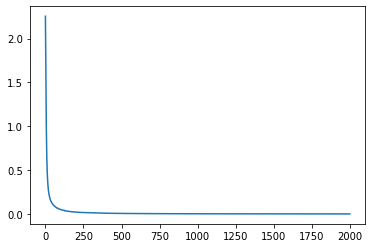

In [9]:
plt.plot(loss_overtime)
plt.show()

## Adjusting hyperparameters based on the validation set

In [12]:
correct, total = 0, 0

for images, labels in valid_loader:
    output = neural_network1(images)
    for y_pred_vect, y_actual in zip(output, labels):
        _, num_idx = torch.max(y_pred_vect, 0)
        correct += (1 if num_idx == y_actual else 0)
        total += 1
print(f"The accuracy for the validation set is {(correct/total)*100}%")

The accuracy for the validation set is 97.49303621169916%


## Testing the accuracy on the test set

In [13]:
for images, labels in test_loader:
    output = neural_network1(images)
    for y_pred_vect, y_actual in zip(output, labels):
        _, num_idx = torch.max(y_pred_vect, 0)
        correct += (1 if num_idx == y_actual else 0)
        total += 1
print(f"The accuracy for the test set is {(correct/total)*100}%")

The accuracy for the test set is 97.76951672862454%
